### Classifying the phase of the two-dimensional transverse field Ising-model

In [1]:
pip install tensorflow==2.4.1 tensorflow_quantum

     |████████████████████████████████| 394.3MB 41kB/s 
     |████████████████████████████████| 7.8MB 27.2MB/s 
     |████████████████████████████████| 471kB 41.6MB/s 
     |████████████████████████████████| 2.9MB 26.9MB/s 
     |████████████████████████████████| 3.8MB 20.3MB/s 
     |████████████████████████████████| 92kB 8.9MB/s 
     |████████████████████████████████| 5.6MB 13.3MB/s 
     |████████████████████████████████| 92kB 9.7MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 389kB 50.0MB/s 
     |████████████████████████████████| 1.5MB 50.8MB/s 
ERROR: cirq-google 0.11.0 has requirement protobuf~=3.13.0, but you'll have protobuf 3.17.3 which is incompatible.
ERROR: tensorflow-quantum 0.5.1 has requirement protobuf==3.13.0, but you'll have protobuf 3.17.3 which is incompatible.
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimat

For the two-dimensional transverse field Ising-model (TFIM) on a rectangular lat-tice, the available data sets are 3×3, 4×3, and 4×4 lattice for $g\in[2.5,3.5]$. To load the data, we use the `tfi_rectangular` function to obtain both the circuits and labels indicating the ordered $(y= 1)$ and disordered $(y=−1)$ phase. Here, we consider the 4×4 lattice.

In [14]:
import tensorflow_quantum as tfq
import tensorflow as tf
import cirq
import numpy as np
import sympy
nspins = 16
qubits = cirq.GridQubit.rect(nspins, 1)

circuits, labels, _ , add_info = tfq.datasets.tfi_chain(qubits)

labels = np.array(labels)
print(labels)
labels[labels >= 1] = 1.0
labels = labels * 2 - 1
print(labels)
x_train_tfcirc = tfq.convert_to_tensor(circuits)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1]


The variable `circuits` now contains 51 quantum circuits that prepare a>0.999 fidelity ground states of the two-dimensional TFIM at the respective order valueg of the model. Next, we add the layers of our hardware efficient ansatz. We parameterize each gate in the classifier individually.

In [3]:
def add_layer_nearest_neighbours(circuit, qubits, gate, prefix):
    for i, q in enumerate(zip(qubits, qubits[1:])):
        symbol = sympy.Symbol(prefix + '-' + str(i))
        circuit.append(gate(*q) ** symbol)


def add_layer_single(circuit, qubits, gate, prefix):
    for i, q in enumerate(qubits):
        symbol = sympy.Symbol(prefix + '-' + str(i))
        circuit.append(gate(q) ** symbol)

def create_quantum_model(N, num_layers):
    qubits = cirq.GridQubit.rect(N, 1)
    circuit = cirq.Circuit()
    for l in range(num_layers):
        add_layer_single(circuit, qubits, cirq.X, f"x_{l}")
        add_layer_nearest_neighbours(circuit, qubits, cirq.XX, f"xx_{l}")
        add_layer_single(circuit, qubits, cirq.Z, f"z_{l}")

    readout = [cirq.Z(q) for q in qubits]
    return circuit, readout

We can compile the model with other metrics to track during training. In our case, we use thebhinge accuracy to count the number of missclasified datapoints.

In [4]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

Finally, we create the model,

In [5]:
circuit, output = create_quantum_model(nspins, 3)

and seamlessly integrate our quantum classifier into a Keras

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(circuit, output),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.tanh)
])
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[hinge_accuracy])

If we set the maximum number of epochs and batch size,we are ready to fit the model. We add an early stoppingcallback to make sure that training can terminate whenthe loss no longer decreases consistently.

In [8]:
epochs = 25
batch_size = 32

qnn_history = model.fit(
    x_train_tfcirc, labels,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping('loss', patience=5)])

predictions = model.predict(x_train_tfcirc)

Epoch 1/25
3/3 [==============================] - 15s 5s/step - loss: 0.1124 - hinge_accuracy: 1.0000
Epoch 2/25
3/3 [==============================] - 15s 5s/step - loss: 0.1043 - hinge_accuracy: 0.9804
Epoch 3/25
3/3 [==============================] - 15s 5s/step - loss: 0.0978 - hinge_accuracy: 0.9896
Epoch 4/25
3/3 [==============================] - 15s 5s/step - loss: 0.0942 - hinge_accuracy: 0.9804
Epoch 5/25
3/3 [==============================] - 15s 5s/step - loss: 0.0897 - hinge_accuracy: 0.9896
Epoch 6/25
3/3 [==============================] - 15s 5s/step - loss: 0.0848 - hinge_accuracy: 1.0000
Epoch 7/25
3/3 [==============================] - 15s 5s/step - loss: 0.0832 - hinge_accuracy: 1.0000
Epoch 8/25
3/3 [==============================] - 15s 5s/step - loss: 0.0809 - hinge_accuracy: 1.0000
Epoch 9/25
3/3 [==============================] - 15s 5s/step - loss: 0.0775 - hinge_accuracy: 1.0000
Epoch 10/25
3/3 [==============================] - 15s 5s/step - loss: 0.0763 - hi

After the model is trained, we can predict the labels of the phases from the model output ̄and visualize how well the model has captured the phase transition. 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:912: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  bbox = Bbox(np.array([[x1, y1], [x2, y2]]))


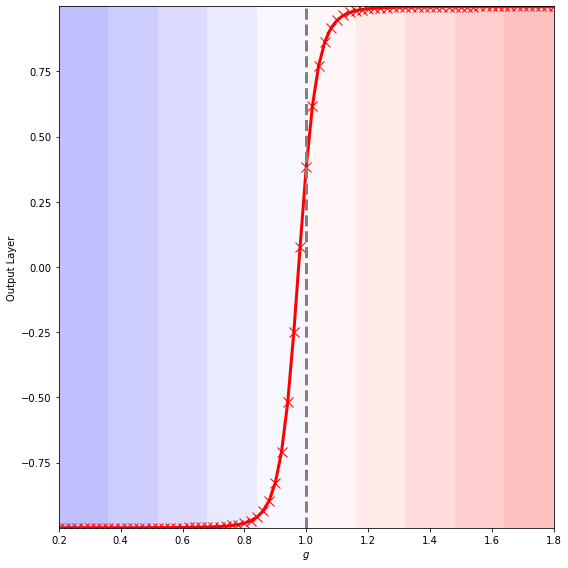

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(8, 8)
cmap = plt.get_cmap('PuOr')
labels = []
for info in add_info:
    labels.append(info.g)
x = np.linspace(labels[0], labels[-1], 10)
yarr = np.vstack((x,))
axs.imshow(yarr, extent=(min(x), max(x), min(predictions), max(predictions)),
           cmap=plt.cm.bwr, aspect='auto', alpha=0.25)
axs.plot(labels, predictions, linewidth=3, label=f'N = {nspins}', color='red', Marker="x", Markersize = 10)
axs.plot([1.0,1.0], [-1., 1.0], linewidth=3, label=f'N = {nspins}', color='gray', Markersize = 10, Linestyle='--')

axs.set_xlabel('$g$')
axs.set_ylabel('Output Layer')
axs.set_ylim([min(predictions), max(predictions)])
plt.tight_layout()
plt.show()

In this figure, we see that the inflection point at $\hat{y}=0$ coincides with the phase transition at $g=1.0$, as expected. 